In [1]:
import os
import numpy as np
import pandas as pd
pd.options.display.max_rows = 120
import torch
import torch.nn as nn
import torch.optim as optim
import re
import pickle
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.decomposition import PCA 

%matplotlib inline

## Загружаем корпус текстов http://opencorpora.org/files/export/annot/annot.opcorpora.no_ambig.nonmod.xml.bz2

In [2]:
# открываем скачанные данные 
path = r'C:\Users\Anton\Documents\NLP\annot_opcorpora_no_ambig_nonmod.xml'
root = ET.parse(path).getroot()

In [3]:
# создаем список с предложениями и словарь с частоами слов
sentences=[]
token_freq ={}

for st in root.iter('source'):
    l=re.sub(r'[^А-я\s]+','',st.text)
    splitted_line = l.strip().split()
    words = [w.lower() for w in splitted_line] 
    sentences.append(words)

    for word in words:
        if word in token_freq:
            token_freq[word]+=words.count(word)
        else:
            token_freq[word]=words.count(word)

In [5]:
# записываем словарь в датафрейм для удобства
tf=pd.DataFrame.from_dict(token_freq,orient='index',columns=['f'])
tf.columns=['word','fq']
# зададим параметр размера модели
n = len(token_freq)

In [6]:
n

49800

In [7]:
# функция извлечения индекса по слову
wrd12=tf.word.values
def ind(wr):
    return np.where(wrd12==wr)[0][0]

In [94]:
tf.sort_values('fq').tail(5)

,word,fq
29,с,2500
23,не,2697
31,на,3931
65,и,8480
9,в,12516


In [9]:
%%time
# создаем матрицу частот слов в предложениях
tz=torch.zeros([len(token_freq),len(sentences)])
i=0
for s in sentences:
    for w in s:
        tz[ind(w),i]+=1
    i+=1

Wall time: 2min 51s


In [10]:
# функция возвращает массив из индексов окружающих слов в предложении
def get_context(sent,wr,num_c):
    ls=[]
    while wr in sent:
        ind_0 = sent.index(wr)
        
        start_n = max(0,ind_0-num_c)
        finish_n = min(len(sent)-1,ind_0+num_c)

        for i in range(start_n,ind_0):
            ls.append(ind(sent[i]))
        for i in range(ind_0+1,finish_n+1):
            ls.append(ind(sent[i])) 
            
        sent = sent[finish_n+1:]
    return np.array(ls)

In [11]:
%%time
# cnt_freq - словарь со списками контекстов
cnt_freq = {}
num_context = 5

for i in range(n):
    cont_i = np.array([])
    for lll in tz[i,:].nonzero():

        st=sentences[lll[0].item()]
        ls = get_context(st,wrd12[i],num_context)
        cont_i = np.concatenate((cont_i,ls),axis=0)
        
    cnt_freq[i] = cont_i

Wall time: 16min 25s


In [356]:
#создаем модель
wordvec_dim = 100
nn_model = nn.Sequential(
            nn.Linear(n, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, n, bias=False), 
         )

In [357]:
# зададим гиперпараметры 
torch.cuda.empty_cache()
num_epochs=5
bs=1000
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.0003,weight_decay=0.1)
nn_model.train()
nn_model.cuda()

In [79]:
# функция вычисляющая вход и выход (граунд тру вектор) для минибатча

def load_batch(j,bbs):
    inp = torch.zeros(bbs,n)
    out = torch.zeros(bbs,n)

    for i in range(j,j+bbs):
        inp[i-j,i]=1
        # заполняем файл выхода
        c, f = np.unique(cnt_freq[i],return_counts=True)
        s = f.sum()
        for k in range(c.shape[0]):
            out[i-j,int(c[k])]=f[k]/s

    return inp,out

In [421]:
# тренирвока модели
for epoch in range(num_epochs):
    i=0
    while i < n:

        optimizer.zero_grad()
        
        bs_i = min(bs,n-i)
        inp,out=load_batch(i,bs_i)
        i+=bs_i
        
        pred=nn_model(inp.cuda())
        loss=0
     
        for j in range(bs_i):
            sss=torch.dot(out[j,:].float().cuda(),pred[j,:].float())
            loss-=sss
            
        print(-loss.item())
        loss.backward()
        optimizer.step()         

68.87683868408203
67.54765319824219
64.66384887695312
72.1364517211914
65.10150909423828
72.29104614257812
64.01910400390625
65.33568572998047
65.44010162353516
74.05924224853516
71.16705322265625
76.70626831054688
77.73558807373047
75.6688003540039
74.11781311035156
70.95252990722656
67.8078842163086
81.57182312011719
77.51236724853516
75.01705169677734
76.52388763427734
77.58240509033203
77.15371704101562
78.71088409423828
78.74539184570312
73.9654312133789
82.45893096923828
87.37995147705078
83.10379028320312
69.17713165283203
73.46118927001953
67.76529693603516
77.31105041503906
83.41683197021484
80.37814331054688
84.24375915527344
83.7196273803711
90.51564025878906
94.28597259521484
86.99176025390625
84.54607391357422
79.48036193847656
82.12136840820312
82.95025634765625
88.75507354736328
95.77157592773438
69.18270874023438
87.62533569335938
86.1845703125
51.0572624206543
81.21623992919922
79.5866470336914
76.17549896240234
84.9908676147461
76.56674194335938
84.80558013916016
75.1

In [276]:
torch.save(nn_model,'rus1_50_w2v')

# Визуализация и анализ результатов

In [89]:
# функция вычисления компонентов вектора слова
def extract_word_vectors(wrd):
    return nn_model[0].weight.data[:,ind(wrd)]

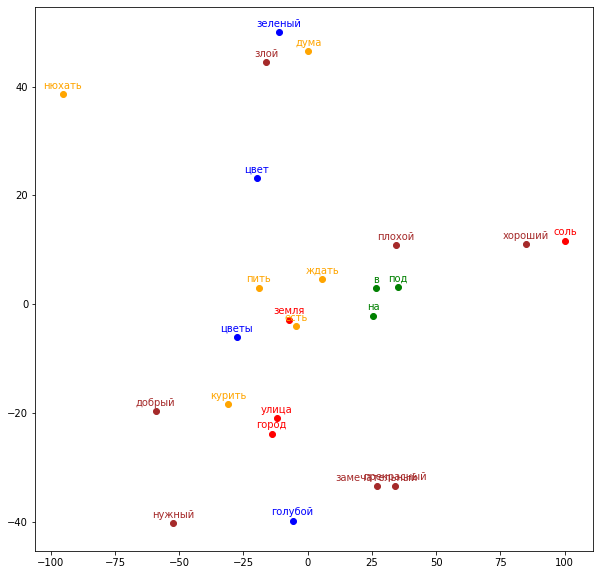

In [422]:
visualize_words = {'green': ["в", "под", "на"], 
                  'blue': ["зеленый", "голубой", "цвет", "цветы"], 
                  'brown': ["хороший", "прекрасный", "замечательный", "нужный", "плохой", 
                          "злой", "добрый"],
                  'orange': ["пить", "курить", "есть", "нюхать", "дума", "ждать"],
                  'red': ['город', 'улица', 'соль', 'земля']
                 }

vvv=extract_word_vectors("кожа").detach().cpu().numpy()
lsw=[]
lsc=[]
for color, words in visualize_words.items():
    i=0
    for wr in words:
        lsw.append(wr)
        lsc.append(color)  
        v_new=extract_word_vectors(wr).detach().cpu()
        vvv=np.vstack((vvv,v_new))
        

points = PCA(n_components=2).fit_transform(vvv)
points = points*1000

df=pd.DataFrame(columns=['x','y','wrd','cl'])

df.x=points[1:,0]
df.y=points[1:,1]
df.wrd=lsw
df.cl=lsc

plt.figure(figsize=(10,10))
for i in range(df.shape[0]):
    r=df.loc[i,:]
    plt.text(r.x,r.y+1,r.wrd, color=r.cl,horizontalalignment='center')
    plt.scatter(r.x,r.y,color=r.cl)


In [423]:
# посмотрим какие вектора оказываются рядом
# построим матрицу с векторами слов
embedding = np.zeros((n,wordvec_dim))
for i in range(n):
    embedding[i,:]=nn_model[0].weight.data[:,i].detach().cpu()  
df_emb=pd.DataFrame(embedding,columns=np.arange(1,wordvec_dim+1))


In [279]:
def sosedi(i,interval):
    emb = df_emb.copy()
    anker=df_emb.loc[i,:]

    for f in range(1,11):
        emb=emb[(emb[f]>anker[f]-interval)  &  (emb[f]<anker[f]+interval) ]
    return emb.index

In [460]:
i = ind('культура')
print(tf.loc[i,'word'])
idx = sosedi(i,0.0005)
print(tf.loc[idx,'word'])

культура
359            наиболее
475        реабилитация
771                лицо
1418            функции
2088           личности
2099             сестра
2174              наука
3633            каждого
3812         управление
4407               вера
7454             совета
7516           культура
11229    санктпетербург
15761           выпуска
19456           рабочая
29608      пролетариата
Name: word, dtype: object
